In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib qt
import os
import mne
from mne.io import concatenate_raws, read_raw_edf
import json
import scipy.io
import pandas as pd
from pandas import read_excel
from scipy.sparse import hstack

## Loading Data 

In [2]:
raw = mne.io.read_raw_edf('06271903_2019.06.27_12.27.14.edf',preload=True)
# print(raw)
# print(raw.info)

Extracting EDF parameters from /Users/bish/Documents/Project arjun/EEG/EMOTIV/Subject 6/4/06271903_2019.06.27_12.27.14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 75007  =      0.000 ...   585.992 secs...


## Markers Data

In [3]:
event_markers = pd.read_excel('06271903_2019.06.27_12.27.14.xlsx')
event_ids = [1,2,3,4,5]
event_keys = {"EyesOpenedStart":1, "EyesOpenedEnd":2, "EyesClosedStart":3, "EyesClosedEnd":4, 
              "PenaltyKickTrial":5}
onset = event_markers["time"]
index = event_markers["marker"]
# print(event_markers)

# Pre-processing

### Pick 4 channels 

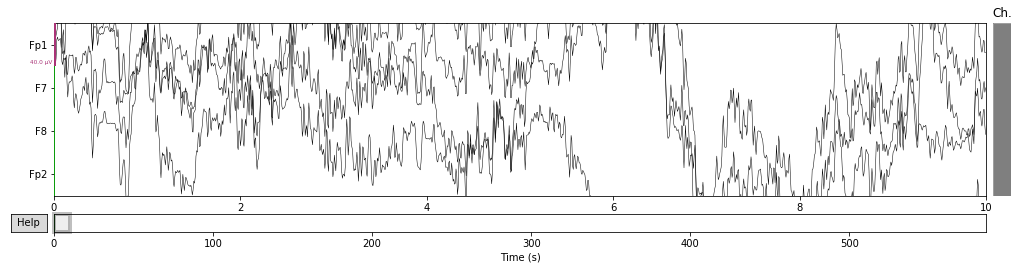

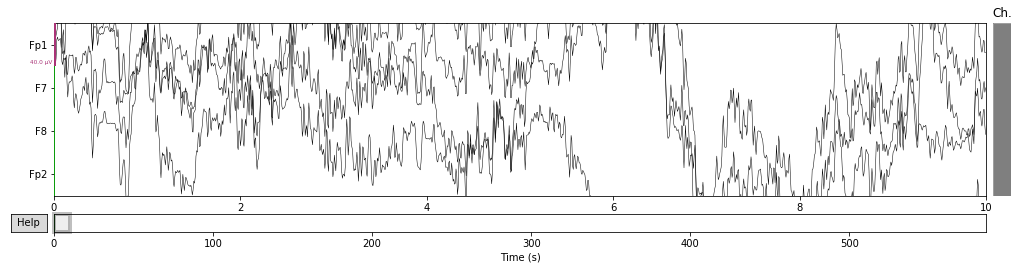

In [4]:
# print(raw.info['ch_names']) 
eeg_ch_names = ['Fp1', 'F7', 'F8', 'Fp2']
num_ele = 4
picks = mne.pick_channels(raw.info["ch_names"], eeg_ch_names)
# print(picks)
pick_raw = raw.copy().pick_channels(eeg_ch_names)
pick_raw.plot()

### Re-referencing with average of all channels

In [5]:
pick_avg_ref, array = mne.set_eeg_reference(pick_raw, ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


### Re-referenced data plot

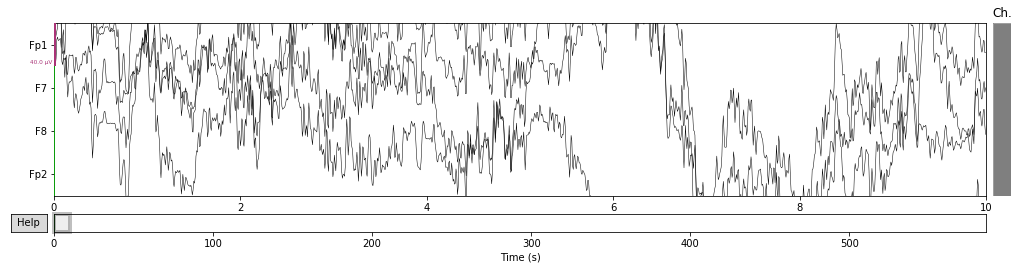

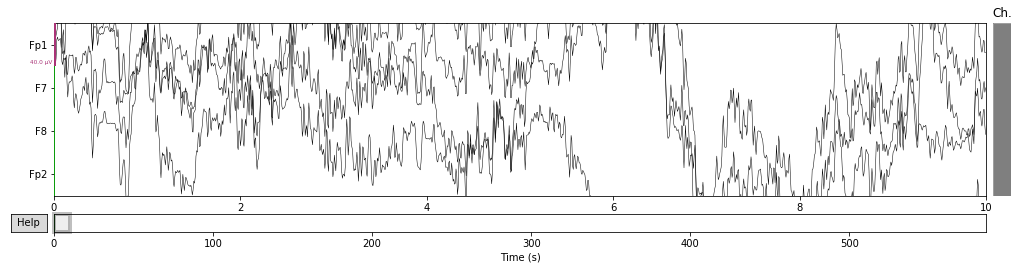

In [6]:
#used preload = True above so that data can be loaded to plot here
pick_raw.plot()

## Inserted standard montage and fit to my raw data

## Filtering 

### FIR band pass filtering (0.1, 45)Hz

In [7]:
l_freq = 0.1
h_freq = 45
filter_pick_avg_ref = pick_avg_ref.filter(l_freq, h_freq, picks=None, filter_length='auto', 
                                        l_trans_bandwidth='auto', h_trans_bandwidth='auto', 
                                        n_jobs=1, method='fir', iir_params=None, phase='zero', 
                                        fir_window='hamming', fir_design='firwin', 
                                        pad='reflect_limited', verbose=None)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 4225 samples (33.008 sec)



### plot filtered data

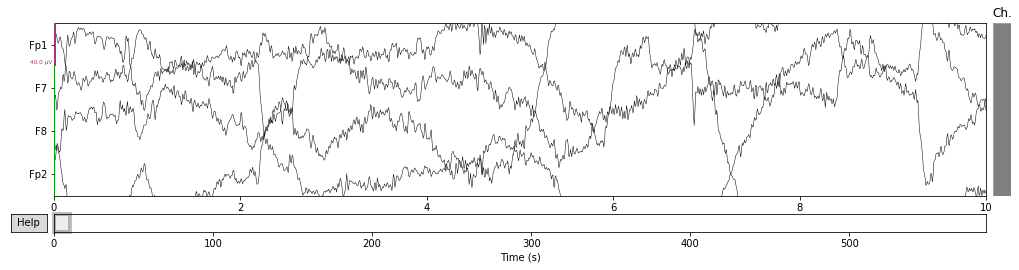

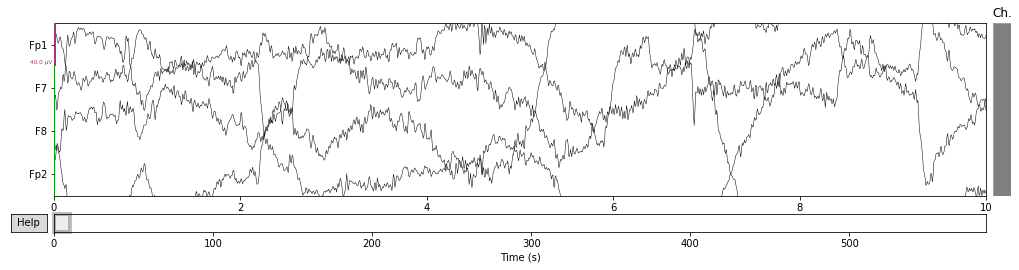

In [8]:
filter_pick_avg_ref.plot()

### Notch filter 60 Hz

In [9]:
freqs = 60
notch_filter_pick_avg_ref = filter_pick_avg_ref.notch_filter(freqs, picks=None, filter_length='auto', notch_widths=None, trans_bandwidth=1.0, n_jobs=1, method='fir', iir_params=None, mt_bandwidth=None, p_value=0.05, phase='zero', fir_window='hamming', fir_design='firwin', pad='reflect_limited', verbose=None)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 sec)



### plot notch-filtered data

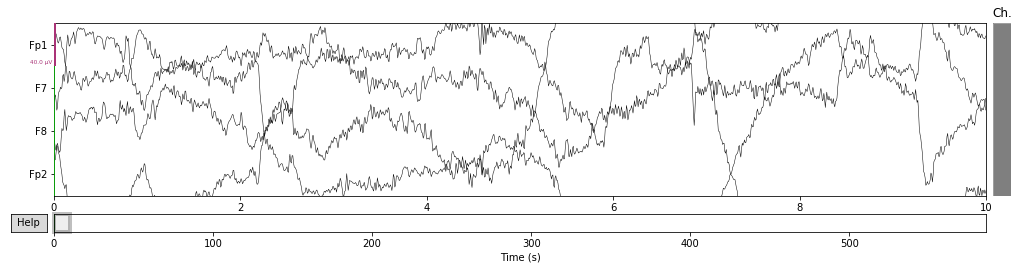

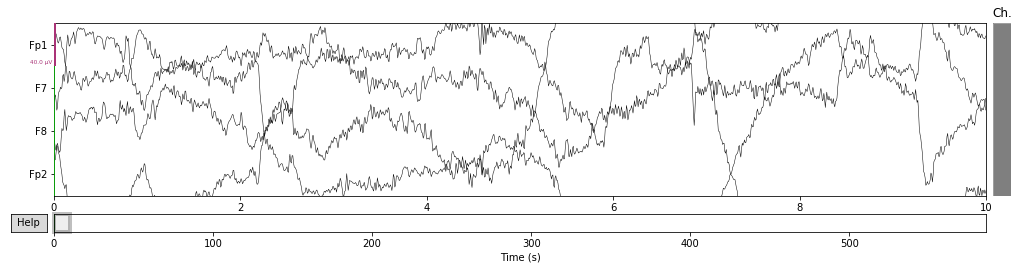

In [10]:
notch_filter_pick_avg_ref.plot()

## Fit data to montage

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


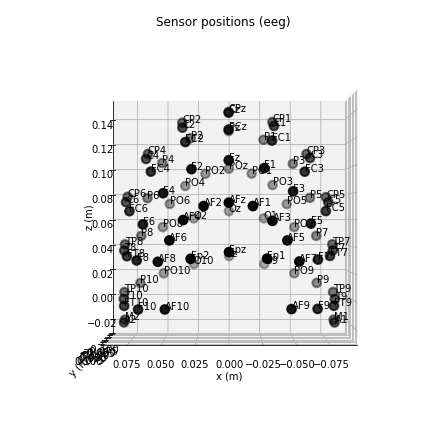

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


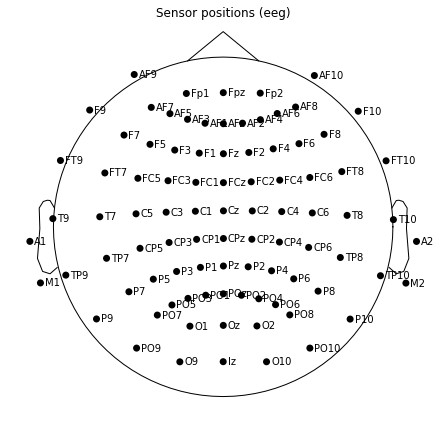

<RawEDF | 06271903_2019.06.27_12.27.14.edf, 4 x 75008 (586.0 s), ~2.3 MB, data loaded>

In [11]:
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
fig = ten_twenty_montage.plot(kind='3d')
fig.gca().view_init(azim=70, elev=15)
ten_twenty_montage.plot(kind='topomap', show_names=True)
notch_filter_pick_avg_ref.set_montage(ten_twenty_montage)

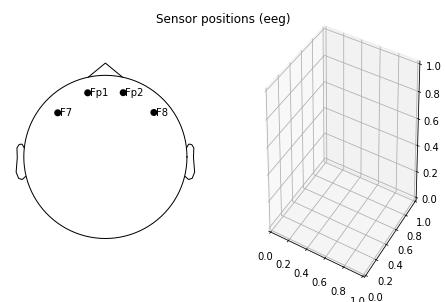

In [12]:
raw_1020 = pick_raw.copy().set_montage(ten_twenty_montage)
fig = plt.figure()
ax2d = fig.add_subplot(121)
ax3d = fig.add_subplot(122, projection='3d')
raw_1020.plot_sensors(ch_type='eeg', axes=ax2d, show_names=True)
raw_1020.plot_sensors(ch_type='eeg', axes=ax3d, kind='3d', show_names=True)
ax3d.view_init(azim=70, elev=15)



# ICA

## Fit to ICA

In [13]:
from mne.preprocessing import ICA
ica = ICA(n_components=4, random_state=97)
ica.fit(notch_filter_pick_avg_ref)

Fitting ICA to data using 4 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 4 components
Fitting ICA took 0.6s.


<ICA  |  raw data decomposition, fit (fastica): 75008 samples, 4 components, channels used: "eeg">

## plot raw data sources (32 comp)

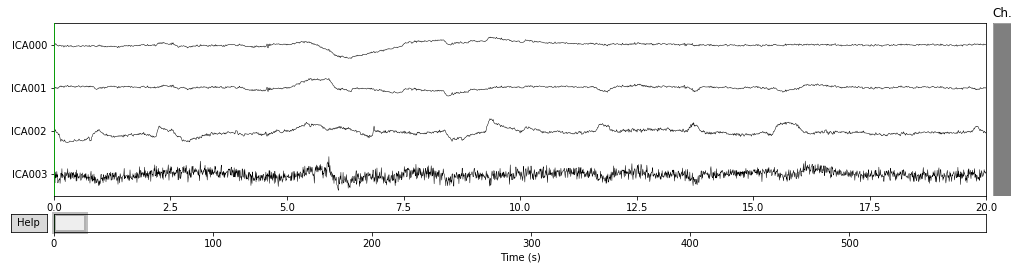

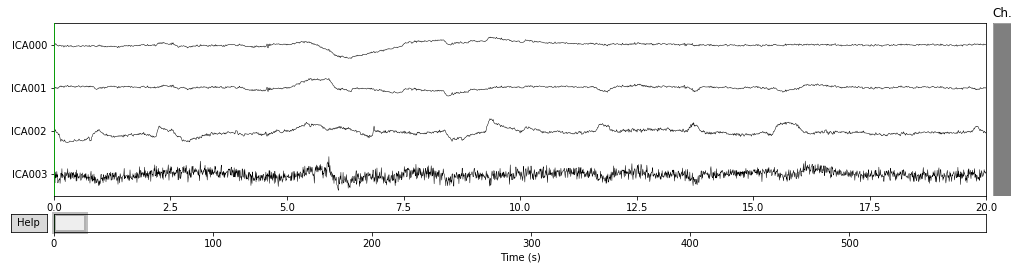

In [14]:
raw.load_data()
ica.plot_sources(notch_filter_pick_avg_ref)

    Using multitaper spectrum estimation with 7 DPSS windows
293 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
293 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
293 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
293 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


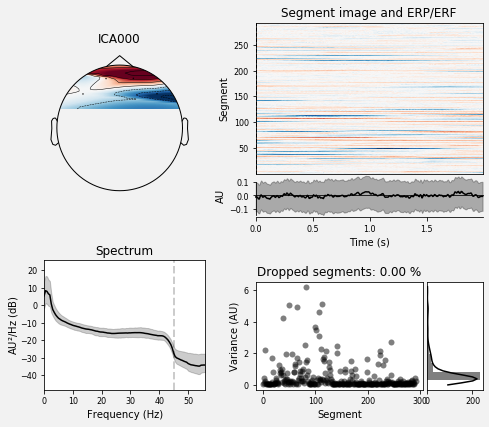

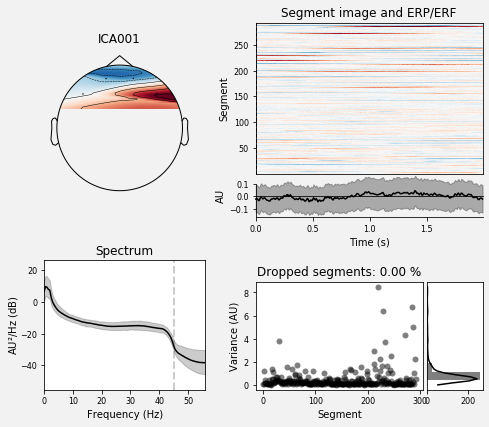

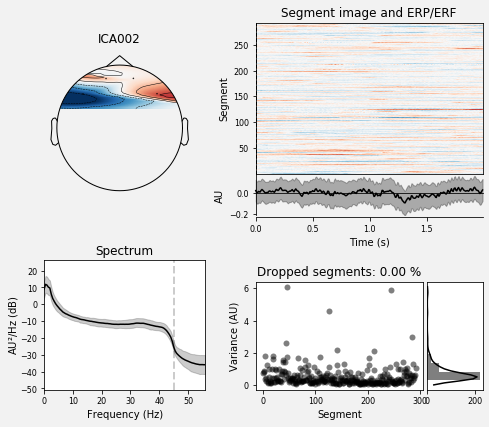

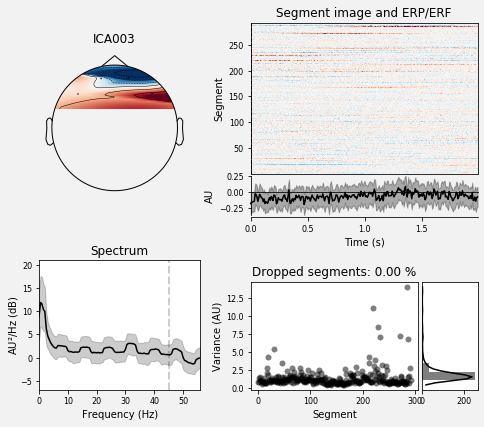

[<Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>]

In [15]:
ica.plot_properties(notch_filter_pick_avg_ref)

Transforming to ICA space (4 components)
Zeroing out 0 ICA components


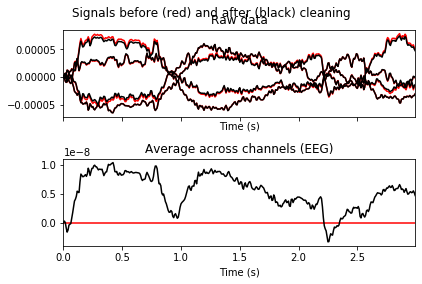

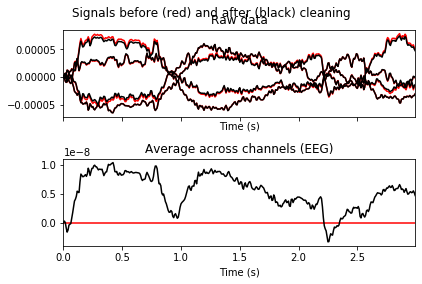

In [16]:
ica.plot_overlay(notch_filter_pick_avg_ref)

## plot ICA fitted comp.

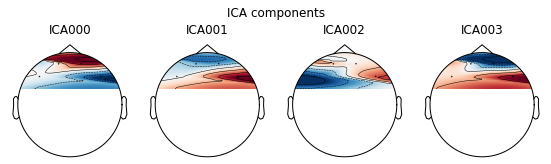

[<Figure size 561.6x169.56 with 4 Axes>]

In [17]:
ica.plot_components()

### Exclude artifacts

In [18]:
ica.exclude = [3]

### Reconstruct after excluding

In [19]:
reconst_raw = notch_filter_pick_avg_ref.copy()
ica.apply(reconst_raw)

Transforming to ICA space (4 components)
Zeroing out 1 ICA component


<RawEDF | 06271903_2019.06.27_12.27.14.edf, 4 x 75008 (586.0 s), ~2.3 MB, data loaded>

## Comparison 

### Before ICA

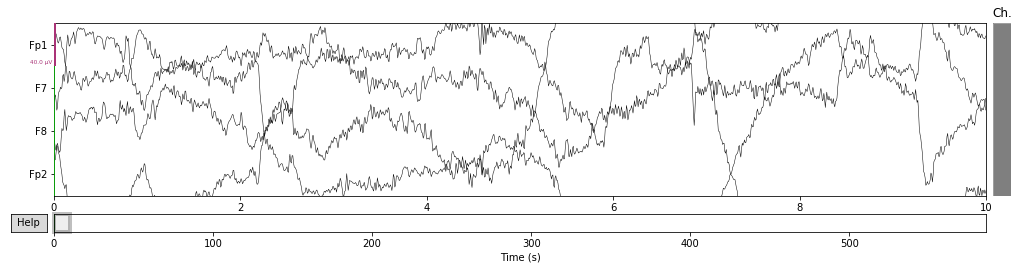

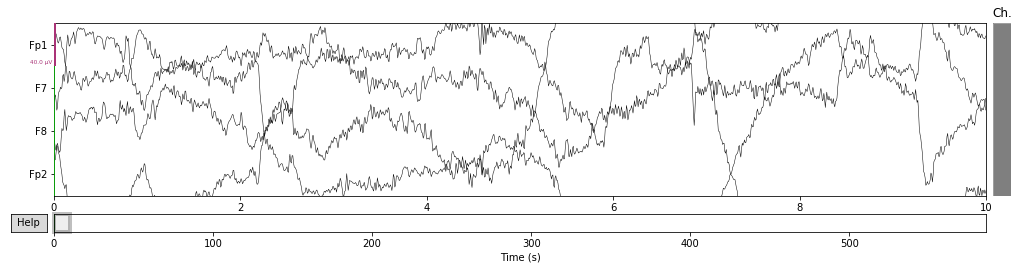

In [20]:
notch_filter_pick_avg_ref.plot()

### After ICA

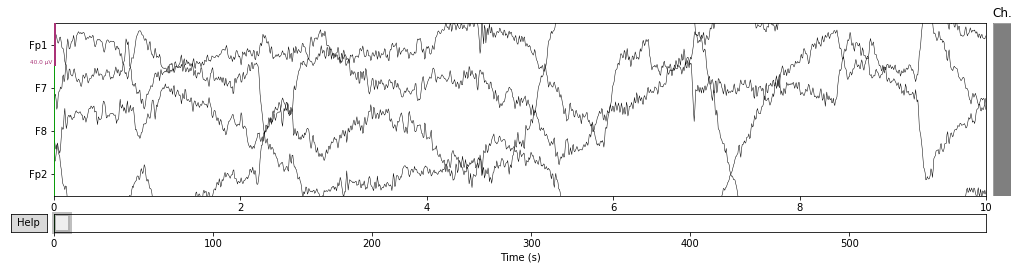

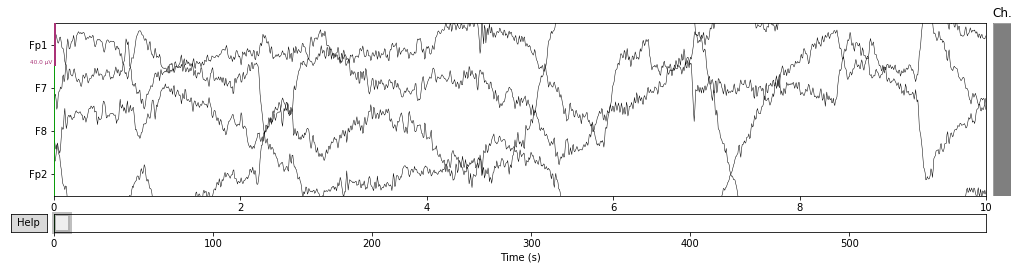

In [21]:
reconst_raw.plot()

## Filtering again 

In [22]:
l_freq = 0.1
h_freq = 45
filter_reconst = reconst_raw.filter(l_freq, h_freq, picks=None, filter_length='auto', 
                                        l_trans_bandwidth='auto', h_trans_bandwidth='auto', 
                                        n_jobs=1, method='fir', iir_params=None, phase='zero', 
                                        fir_window='hamming', fir_design='firwin', 
                                        pad='reflect_limited', verbose=None)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 4225 samples (33.008 sec)



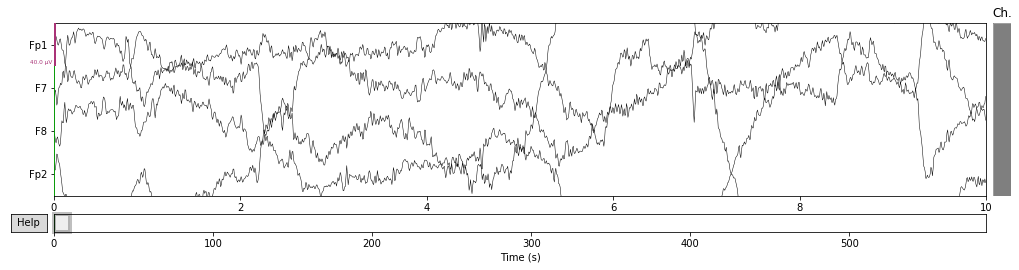

In [23]:
reconst = filter_reconst.plot()

# Epoching data

## based on pkevents.mat excel sheet for this subject

In [24]:
# print(event_markers)
events = np.array(event_markers[["latency","marker","marker"]])
epochs = mne.Epochs(filter_reconst, events, event_id = event_ids, tmin = - 0.5, tmax = 3, baseline=None, picks=None, 
                    preload=False, reject=None, flat=None, proj=True, decim=1, reject_tmin=None, 
                    reject_tmax=None, detrend=None, on_missing='warning', reject_by_annotation=True, 
                    metadata=None, event_repeated='error', verbose=None)
# print(epochs)

54 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


Loading data for 54 events and 449 original time points ...
0 bad epochs dropped
Loading data for 54 events and 449 original time points ...
Loading data for 20 events and 449 original time points ...


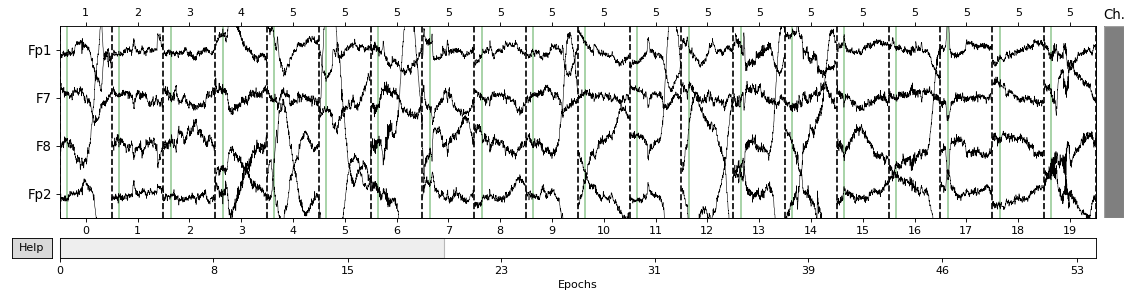

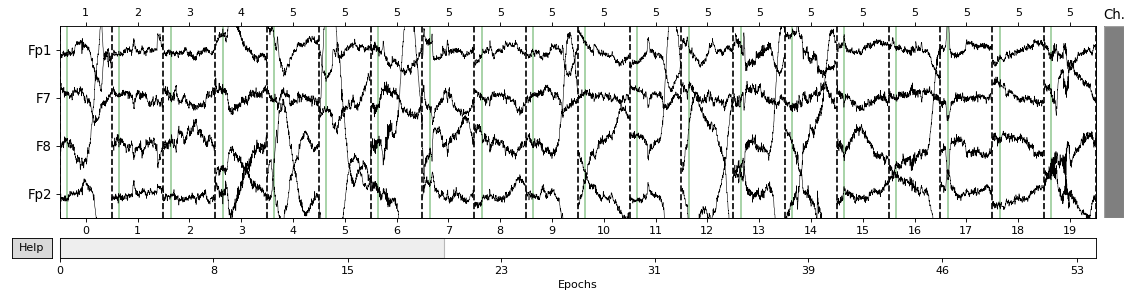

In [25]:
epochs.plot(event_id = event_ids)

# Band power analysis

In [26]:
EyesOpenedStart = epochs[0]
EyesOpenedEnd = epochs[1]
EyesClosedStart = epochs[2]
EyesClosedEnd = epochs[3]


In [27]:
from mne.time_frequency import psd_multitaper
n_fft = 2048


### Multitaper technique

In [28]:
def bandpower(data, sf, low, high, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper

    # Compute the modified periodogram (Welch)
    psd_total, freqs_total = psd_multitaper(data, low_bias=True, proj=True, n_jobs=1)
    psd, freqs = psd_multitaper(data, fmin=low, fmax=high, low_bias=True, proj=True, n_jobs=1)

    # Frequency resolution
    freq_res = freqs_total[1] - freqs_total[0]

    # Find index of band in frequency vector
    # idx_band = np.logical_and(psd[:,] >= low, psd[:,] <= high)
    
    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd, dx=freq_res)

    if relative:
        bp = simps(psd, dx=freq_res) / simps(psd_total, dx=freq_res)
    return bp

In [29]:
sf = 128
delta_low = 0.5
delta_high = 4

theta_low = 4
theta_high = 8

alpha_low = 8
alpha_high = 12

beta_low = 12
beta_high = 30

In [30]:
bp_0_delta = bandpower(epochs[0], sf, low=delta_low, high=delta_high, window_sec=None, relative=True)
bp_0_theta = bandpower(epochs[0], sf, low=theta_low, high=theta_high, window_sec=None, relative=True)
bp_0_alpha = bandpower(epochs[0], sf, low=alpha_low, high=alpha_high, window_sec=None, relative=True)
bp_0_beta = bandpower(epochs[0], sf, low=beta_low, high=beta_high, window_sec=None, relative=True)

# bp_1_delta = bandpower(epochs[1], sf, low=delta_low, high=delta_high, window_sec=None, relative=True)
# bp_1_theta = bandpower(epochs[1], sf, low=theta_low, high=theta_high, window_sec=None, relative=True)
# bp_1_alpha = bandpower(epochs[1], sf, low=alpha_low, high=alpha_high, window_sec=None, relative=True)
# bp_1_beta = bandpower(epochs[1], sf, low=beta_low, high=beta_high, window_sec=None, relative=True)

bp_2_delta = bandpower(epochs[2], sf, low=delta_low, high=delta_high, window_sec=None, relative=True)
bp_2_theta = bandpower(epochs[2], sf, low=theta_low, high=theta_high, window_sec=None, relative=True)
bp_2_alpha = bandpower(epochs[2], sf, low=alpha_low, high=alpha_high, window_sec=None, relative=True)
bp_2_beta = bandpower(epochs[2], sf, low=beta_low, high=beta_high, window_sec=None, relative=True)

# bp_3_delta = bandpower(epochs[3], sf, low=delta_low, high=delta_high, window_sec=None, relative=True)
# bp_3_theta = bandpower(epochs[3], sf, low=theta_low, high=theta_high, window_sec=None, relative=True)
# bp_3_alpha = bandpower(epochs[3], sf, low=alpha_low, high=alpha_high, window_sec=None, relative=True)
# bp_3_beta = bandpower(epochs[3], sf, low=beta_low, high=beta_high, window_sec=None, relative=True)

No projector specified for this dataset. Please consider the method self.add_proj.
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
No projector specified for this dataset. Please consider the method self.add_proj.
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
No projector specified for this dataset. Please consider the method self.add_proj.
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
No projector specified for this dataset. Please consider the method self.add_proj.
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
No projector specified for this dataset. Please consider the method self.add_proj.
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 

### Relative band power average over channels

In [31]:
print("Eyes Opened Start")
print("delta",np.average(bp_0_delta)*100,"%")
print("theta",np.average(bp_0_theta)*100,"%")
print("alpha",np.average(bp_0_alpha)*100,"%")
print("beta",np.average(bp_0_beta)*100,"%\n")

# print("Eyes Opened End")
# print("delta",np.average(bp_1_delta)*100,"%")
# print("theta",np.average(bp_1_theta)*100,"%")
# print("alpha",np.average(bp_1_alpha)*100,"%")
# print("beta",np.average(bp_1_beta)*100,"%\n")

print("Eyes Closed Start")
print("delta",np.average(bp_2_delta)*100,"%")
print("theta",np.average(bp_2_theta)*100,"%")
print("alpha",np.average(bp_2_alpha)*100,"%")
print("beta",np.average(bp_2_beta)*100,"%\n")

# print("Eyes Closed End")
# print("delta",np.average(bp_3_delta)*100,"%")
# print("theta",np.average(bp_3_theta)*100,"%")
# print("alpha",np.average(bp_3_alpha)*100,"%")
# print("beta",np.average(bp_3_beta)*100,"%")

Eyes Opened Start
delta 49.02425025843766 %
theta 0.504111055192632 %
alpha 0.26139151503330676 %
beta 0.47047134280521796 %

Eyes Closed Start
delta 49.855030550742505 %
theta 5.24033498239493 %
alpha 4.014593369004893 %
beta 6.376275693855998 %



In [32]:
print("Delta")
print("Eyes Opened Start",np.average(bp_0_delta)*100,"%")
# print("Eyes Opened End",np.average(bp_1_delta)*100,"%")
print("Eyes Closed Start",np.average(bp_2_delta)*100,"%")
# print("Eyes Closed End",np.average(bp_3_delta)*100,"%\n")

print("Theta")
print("Eyes Opened Start",np.average(bp_0_theta)*100,"%")
# print("Eyes Opened End",np.average(bp_1_theta)*100,"%")
print("Eyes Closed Start",np.average(bp_2_theta)*100,"%")
# print("Eyes Closed End",np.average(bp_3_theta)*100,"%\n")

print("Alpha")
print("Eyes Opened Start",np.average(bp_0_alpha)*100,"%")
# print("Eyes Opened End",np.average(bp_1_alpha)*100,"%")
print("Eyes Closed Start",np.average(bp_2_alpha)*100,"%")
# print("Eyes Closed End",np.average(bp_3_alpha)*100,"%\n")

print("Beta")
print("Eyes Opened Start",np.average(bp_0_beta)*100,"%")
# print("Eyes Opened End",np.average(bp_1_beta)*100,"%")
print("Eyes Closed Start",np.average(bp_2_beta)*100,"%")
# print("Eyes Closed End",np.average(bp_3_beta)*100,"%\n")

Delta
Eyes Opened Start 49.02425025843766 %
Eyes Closed Start 49.855030550742505 %
Theta
Eyes Opened Start 0.504111055192632 %
Eyes Closed Start 5.24033498239493 %
Alpha
Eyes Opened Start 0.26139151503330676 %
Eyes Closed Start 4.014593369004893 %
Beta
Eyes Opened Start 0.47047134280521796 %
Eyes Closed Start 6.376275693855998 %


# Behavioural data

In [33]:
#random win lose array for now
beh_data  = pd.read_excel('outcome_data.xlsx', header=None)
# print(beh_data)
beh_data = np.array(beh_data)
outcome = beh_data[:,3]
print(outcome)
emo = np.array(beh_data[:,4])
foc = np.array(beh_data[:,5])
emo_new = np.zeros(50)
foc_new = np.zeros(50)

[2. 2. 2. 1. 2. 2. 1. 2. 1. 1. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 1. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2.]


In [34]:
# 4 class labeling 
for i in range(0,50):
    if emo[i]<25:
        emo_new[i]=0
    else:
        if emo[i]<50:
            emo_new[i]=1
        else:
            if emo[i]<75:
                emo_new[i]=2
            else:
                if emo[i]<101:
                    emo_new[i]=3
print(emo_new)

for i in range(0,50):
    if foc[i]<25:
        foc_new[i]=0
    else:
        if foc[i]<50:
            foc_new[i]=1
        else:
            if foc[i]<75:
                foc_new[i]=2
            else:
                if foc[i]<101:
                    foc_new[i]=3
print(foc_new)

[2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 3. 2. 2. 2. 2.
 2. 2.]
[2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 3. 3. 3. 2. 3. 2. 2. 1. 1. 1. 1.
 1. 1.]


# Predicting outcome data

# Linear Discriminant Analysis

In [35]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Epochs to array

In [36]:
#selecting all the channels and converting to dataframe
df = epochs[4:54].to_data_frame()
#converting dataframe to numpy array
X = df.to_numpy()
#intialising outcome for that event by random number 1, 2 for now
from numpy import random
y = np.zeros(len(X))
for i in range(4,54):
    idx = np.where(df['epoch'] == i)
    y[idx] = outcome[i-4]

Loading data for 50 events and 449 original time points ...


In [37]:
# evaluate a lda model on the dataset
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# All channels LDA

In [38]:
X_ch = X[:,3:7]
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.860 (0.000)


# Single channel LDA

In [39]:
def single_channel_LDA(X_ch, y, column_number):
    #choosing 2:event ids, 3: channel 1 onwards
    X_ch = X_ch[:,column_number].reshape(-1,1)
    # define model
    model = LinearDiscriminantAnalysis()
    # define model evaluation method
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X_ch, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # summarize result
    print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    return mean(scores)

# Mean prediction accuracy

In [40]:
print("Channels and Mean accuracies")
for i in range(4):
    a = single_channel_LDA(X_ch, y, i)

Channels and Mean accuracies
Mean Accuracy: 0.860 (0.000)
Mean Accuracy: 0.860 (0.000)
Mean Accuracy: 0.860 (0.000)
Mean Accuracy: 0.860 (0.000)


# Logistic regression

In [41]:
from sklearn.linear_model import LogisticRegression
# define model
model = LogisticRegression()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.860 (0.000)


In [42]:
def single_channel_reg(X_ch, y, column_number):
    #choosing 2:event ids, 3: channel 1 onwards
    X_ch = X_ch[:,column_number].reshape(-1,1)
    # define model
    model = LogisticRegression()
    # define model evaluation method
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X_ch, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # summarize result
    print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    return mean(scores)

In [43]:
print("Channels and Mean accuracies")
for i in range(4):
    a = single_channel_reg(X_ch, y, i)

Channels and Mean accuracies
Mean Accuracy: 0.860 (0.000)
Mean Accuracy: 0.860 (0.000)
Mean Accuracy: 0.860 (0.000)
Mean Accuracy: 0.860 (0.000)


# SVM classifier

In [44]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn import datasets, svm, metrics
# define model
model = LinearSVC(dual = False)
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.860 (0.000)


In [45]:
def single_channel_svc(X_ch, y, column_number):
    #choosing 2:event ids, 3: channel 1 onwards
    X_ch = X_ch[:,column_number].reshape(-1,1)
    # define model
    model = LinearSVC(dual = False)
    # define model evaluation method
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X_ch, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # summarize result
    print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    return mean(scores)

In [46]:
print("Channels and Mean accuracies")
for i in range(4):
    a = single_channel_svc(X_ch, y, i)

Channels and Mean accuracies
Mean Accuracy: 0.860 (0.000)
Mean Accuracy: 0.860 (0.000)
Mean Accuracy: 0.860 (0.000)
Mean Accuracy: 0.860 (0.000)


# Predicting emo/foc data

## y_emo, y_foc

In [47]:
y_emo = np.zeros(len(X))
y_foc = np.zeros(len(X))
for i in range(4,54):
    idx = np.where(df['epoch'] == i)
    y_emo[idx] = emo_new[i-4]
    y_foc[idx] = foc_new[i-4]

# plot beh data

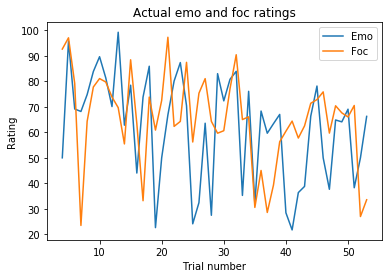

In [50]:
epoch_idx = np.arange(4,54,1)
plt.title("Actual emo and foc ratings")
plt.xlabel("Trial number")
plt.ylabel("Rating")
plt.plot(epoch_idx, emo, label="Emo")
plt.plot(epoch_idx, foc, label="Foc")
plt.legend()
plt.savefig("Behavioural ratings")

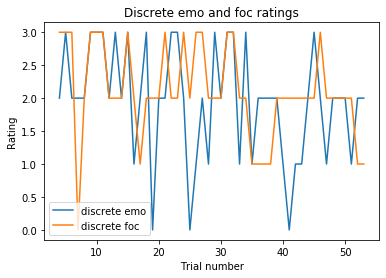

In [51]:
plt.title("Discrete emo and foc ratings")
plt.xlabel("Trial number")
plt.ylabel("Rating")
plt.plot(epoch_idx, emo_new, label="discrete emo")
plt.plot(epoch_idx, foc_new, label="discrete foc")
plt.legend()
plt.savefig("Discretised behavioural ratings")

## without outcome information

## Multi-class classification

In [48]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.svm import LinearSVC

from sklearn.preprocessing import StandardScaler

## Emo ratings classification

### one vs rest (ovr)

In [70]:
clf_ovr_emo = make_pipeline(StandardScaler(), 
                    OneVsRestClassifier(LinearSVC(random_state=0,max_iter=10000)))
# define model
model = clf_ovr_emo
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_emo, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))                                                                                     

Mean Accuracy: 0.900 (0.000)


### one vs one (ovo)

In [71]:
clf_ovo_emo = make_pipeline(StandardScaler(), 
                    OneVsOneClassifier(LinearSVC(random_state=0,max_iter=10000)))
# define model
model = clf_ovo_emo
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_emo, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores))) 

Mean Accuracy: 0.900 (0.000)


### output code classifier (occ)

In [72]:
clf_occ_emo = make_pipeline(StandardScaler(), 
                    OutputCodeClassifier(LinearSVC(random_state=0,max_iter=10000)))
# define model
model = clf_occ_emo
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_emo, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.767 (0.298)


# FOC ratings classification

In [73]:
clf_ovr_foc = make_pipeline(StandardScaler(), 
                    OneVsRestClassifier(LinearSVC(random_state=0,max_iter=10000)))
# define model
model = clf_ovr_foc
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_foc, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))                                                                                     

Mean Accuracy: 0.960 (0.000)


In [74]:
clf_ovo_foc = make_pipeline(StandardScaler(), 
                    OneVsOneClassifier(LinearSVC(random_state=0,max_iter=10000)))
# define model
model = clf_ovo_foc
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_foc, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores))) 

KeyboardInterrupt: 

In [ ]:
clf_occ_foc = make_pipeline(StandardScaler(), 
                    OutputCodeClassifier(LinearSVC(random_state=0,max_iter=10000)))
# define model
model = clf_occ_foc
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_foc, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

# LDA

## all channel LDA emo and foc

In [61]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_emo, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.845 (0.002)


In [62]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_foc, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.785 (0.002)


## Single channel LDA

In [49]:
print("Channels and Mean accuracies- EMO")
for i in range(4):
    a_emo = single_channel_LDA(X_ch, y_emo, i)
print("Channels and Mean accuracies- FOC")
for i in range(4):
    a_foc = single_channel_LDA(X_ch, y_foc, i)

Channels and Mean accuracies- EMO
Mean Accuracy: 0.847 (0.002)
Mean Accuracy: 0.840 (0.000)
Mean Accuracy: 0.839 (0.001)
Mean Accuracy: 0.840 (0.000)
Channels and Mean accuracies- FOC
Mean Accuracy: 0.786 (0.002)
Mean Accuracy: 0.780 (0.000)
Mean Accuracy: 0.779 (0.001)
Mean Accuracy: 0.780 (0.000)


# with outcome information

In [50]:
X_out = np.zeros((len(X_ch),len(X_ch[1])+1))
X_out[:,:-1] = X_ch
X_out[:,len(X_ch[1])] = y

# All channel LDA EMO and FOC

In [66]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_out, y_emo, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.845 (0.002)


In [67]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_out, y_foc, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.784 (0.002)


In [51]:
print("Channels and Mean accuracies- EMO")
for i in range(4):
    a_emo = single_channel_LDA(X_out, y_emo, i)
print("Channels and Mean accuracies- FOC")
for i in range(4):
    a_foc = single_channel_LDA(X_out, y_foc, i)

Channels and Mean accuracies- EMO
Mean Accuracy: 0.847 (0.002)
Mean Accuracy: 0.840 (0.000)
Mean Accuracy: 0.839 (0.001)
Mean Accuracy: 0.840 (0.000)
Channels and Mean accuracies- FOC
Mean Accuracy: 0.786 (0.002)
Mean Accuracy: 0.780 (0.000)
Mean Accuracy: 0.779 (0.001)
Mean Accuracy: 0.780 (0.000)


# Partial data predictions

In [ ]:
# function to choose timepoints and their outcomes 
def time_point(df, freq, time_start, time_end, outcome):
    sample_start = int(time_start * freq / 1000)
    sample_end = int(time_end * freq / 1000)
    result = np.empty(5)
    df_new = df.iloc[:, 2:]
    for i in range(4,54):
        epoch_rows = df_new.loc[df['epoch'] == i]
        sample_rows = epoch_rows.iloc[ sample_start : sample_end + 1 ]
        sample = sample_rows.to_numpy()
        result = np.vstack([result, sample])
    new_X = np.delete(result, 0, 0)
    new_y = np.zeros(len(new_X))
    for i in range(4,54):
        idx = np.where(new_X[:,0] == i)
        new_y[idx] = outcome[i-4]
    new_X = np.delete(new_X, 0, 1)
    
    return new_X, new_y
        

# Choose timepoints

In [ ]:
def all_channel_LDA(X_ch, y):
    # define model
    model = LinearDiscriminantAnalysis()
    # define model evaluation method
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X_ch, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # summarize result
#     print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    return mean(scores)

In [ ]:
# function to move a window through the dataset and check prediction of each window
def window_prediction_all_LDA(df, X, outcome, freq, window_ms):
    mean_acc = []
    start = 0
    flag = 0
    x_flag = []
    end = start + window_ms
    while(end <= 3550):
        new_X, new_y = time_point(df, 120, start, end, outcome)
#         print(new_X, new_y)
#         new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, test_size=0.33, random_state=42)
        acc = all_channel_LDA(new_X, new_y)
        mean_acc.append(acc)
        x_flag.append(window_ms + flag * window_ms)
        start = start + window_ms
        end = start + window_ms
        flag = flag + 1
#         print(flag)
#     print(end)
    plt.title("Window size 50ms, prediction of outcome")
    plt.xlabel("time in ms")
    plt.ylabel("mean accuracy")
    fig = plt.plot(x_flag, mean_acc, "-ok")
    return fig

In [ ]:
fig = window_prediction_all_LDA(df, X, outcome, 120, 50)
plt.savefig("50ms_prediction")

# Single channel LDA window prediction of trials

In [ ]:
def single_channel_LDA(X_ch, y, column_number):
    #choosing 2:event ids, 3: channel 1 onwards
    X_ch = X_ch[:,column_number].reshape(-1,1)
    # define model
    model = LinearDiscriminantAnalysis()
    # define model evaluation method
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X_ch, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # summarize result
#     print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    return mean(scores)

In [ ]:
def window_prediction_single_LDA(df, X, outcome, freq, window_ms):

    start = 0
    flag = 0
    x_flag = []
    end = start + window_ms
    num = (3550 - start)/ window_ms
    mean_acc = np.empty((4, int(num)))
    while(end <= 3550):
        new_X, new_y = time_point(df, 120, start, end, outcome)
#         new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, test_size=0.33, random_state=42)
        for i in range(32):
            acc = single_channel_LDA(new_X, new_y, i)
            mean_acc[i,flag] = acc
        
        x_flag.append(window_ms + flag*window_ms)
        start = start + window_ms
        end = start + window_ms
        flag = flag + 1
    
    plt.title("Window size 50ms, prediction of outcome, channel wise")
    plt.xlabel("time in ms")
    plt.ylabel("mean accuracy")
    for i in range(4):
        plt.plot(x_flag, mean_acc[i,:], label="Channel {}".format(i+1))
    plt.legend()
    plt.savefig("Channel wise LDA for 50mms window in trials")
    return 0

In [ ]:
window_prediction_single_LDA(df, X_ch, outcome, 120, 50)

# Partial data to predict beh data

In [ ]:
def time_point_beh(df, freq, time_start, time_end, emo_new, foc_new):
    sample_start = int(time_start * freq / 1000)
    sample_end = int(time_end * freq / 1000)
    result = np.empty(5)
    df_new = df.iloc[:, 2:]
    for i in range(4,54):
        epoch_rows = df_new.loc[df['epoch'] == i]
        sample_rows = epoch_rows.iloc[ sample_start : sample_end + 1 ]
        sample = sample_rows.to_numpy()
        result = np.vstack([result, sample])
    new_X = np.delete(result, 0, 0)
    
    new_y_emo = np.zeros(len(new_X))
    new_y_foc = np.zeros(len(new_X))
    for i in range(4,54):
        idx = np.where(new_X[:,0] == i)
        new_y_emo[idx] = emo_new[i-4]
        new_y_foc[idx] = foc_new[i-4]
    
    new_X = np.delete(new_X, 0, 1)
    return new_X, new_y_emo, new_y_foc
        

In [ ]:
def emo_window_prediction_all_LDA(df, X, emo_new, foc_new, freq, window_ms):
    mean_acc_emo = []
    start = 0
    flag = 0
    x_flag = []
    end = start + window_ms
    while(end <= 3550):
        new_X, new_y_emo, new_y_foc = time_point_beh(df, 120, start, end, emo_new, foc_new)
#         new_X_train, new_X_test, new_y_emo_train, new_y_emo_test = train_test_split(new_X, new_y_emo, test_size=0.33, random_state=42)
        acc_emo = all_channel_LDA(new_X, new_y_emo)
        mean_acc_emo.append(acc_emo)
        x_flag.append(window_ms + flag*window_ms)
        start = start + window_ms
        end = start + window_ms
        flag = flag + 1
    plt.title("Window size 50ms, prediction of EMO rating")
    plt.xlabel("time in ms")
    plt.ylabel("mean accuracy")
    fig = plt.plot(x_flag, mean_acc_emo, "-ok")
    return fig

In [ ]:
emo_window_prediction_all_LDA(df, X, emo_new, foc_new, 120, 50)
plt.savefig("All_channel_LDA_EMO_window_50ms")

In [ ]:
def foc_window_prediction_all_LDA(df, X, emo_new, foc_new, freq, window_ms):
    mean_acc_foc = []
    start = 0
    flag = 0
    x_flag = []
    end = start + window_ms
    while(end <= 3550):
        new_X, new_y_emo, new_y_foc = time_point_beh(df, 120, start, end, emo_new, foc_new)
#         new_X_train, new_X_test, new_y_foc_train, new_y_foc_test = train_test_split(new_X, new_y_foc, test_size=0.33, random_state=42)
        acc_foc = all_channel_LDA(new_X, new_y_foc)
        mean_acc_foc.append(acc_foc)
        x_flag.append(window_ms + flag*window_ms)
        start = start + window_ms
        end = start + window_ms
        flag = flag + 1
    plt.title("Window size 50ms, prediction of FOC rating")
    plt.xlabel("time in ms")
    plt.ylabel("mean accuracy")
    fig = plt.plot(x_flag, mean_acc_foc, "-ok")
    return fig

In [ ]:
foc_window_prediction_all_LDA(df, X, emo_new, foc_new, 120, 50)
plt.savefig("All_channel_LDA_FOC_window_50ms")

# Correlation

In [501]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(outcome)
plt.savefig("partial_Corr_outcome")
# most positive for lag = 13
# most negative for lag = 10

In [508]:
plot_pacf(emo)
plt.savefig("partial_corr_emo_cont.")

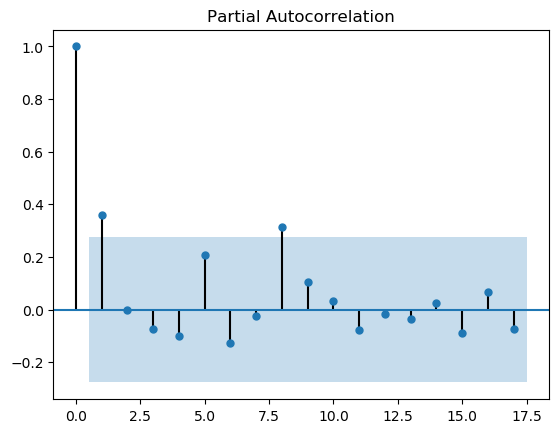

In [507]:
plot_pacf(emo_new)
plt.savefig("partial_Corr_emo_disc")

In [510]:
plot_pacf(foc)
plt.savefig("partial_corr_foc_cont.")

In [511]:
plot_pacf(foc_new)
plt.savefig("partial_Corr_foc_disc")

# Randomisation

# Shuffle outcome

In [52]:
outcome_shuffle = np.random.permutation(outcome)

In [53]:
y_shuffle = np.zeros(len(X))
for i in range(4,54):
    idx = np.where(df['epoch'] == i)
    y_shuffle[idx] = outcome_shuffle[i-4]

In [54]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_shuffle, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.860 (0.000)


In [55]:
print("Channels and Mean accuracies")
for i in range(4):
    a = single_channel_LDA(X_ch, y_shuffle, i)

Channels and Mean accuracies
Mean Accuracy: 0.860 (0.000)
Mean Accuracy: 0.860 (0.000)
Mean Accuracy: 0.860 (0.000)
Mean Accuracy: 0.860 (0.000)


## Random outcome mapped to X

In [59]:
outcome_random = np.random.randint(2, size=len(outcome)) + 1

In [60]:
y_random = np.zeros(len(X))
for i in range(4,54):
    idx = np.where(df['epoch'] == i)
    y_random[idx] = outcome_random[i-4]

# All channel LDA

In [61]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_random, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.573 (0.009)


In [62]:
print("Channels and Mean accuracies")
for i in range(4):
    a = single_channel_LDA(X_ch, y_random, i)

Channels and Mean accuracies
Mean Accuracy: 0.540 (0.000)
Mean Accuracy: 0.541 (0.009)
Mean Accuracy: 0.544 (0.003)
Mean Accuracy: 0.565 (0.006)


# complete random y mapped to X

In [63]:
y_crandom = np.random.randint(2, size = len(X_ch)) + 1

In [64]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_ch, y_crandom, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.505 (0.008)


In [65]:
print("Channels and Mean accuracies")
for i in range(4):
    a = single_channel_LDA(X_ch, y_crandom, i)

Channels and Mean accuracies
Mean Accuracy: 0.506 (0.007)
Mean Accuracy: 0.509 (0.009)
Mean Accuracy: 0.505 (0.008)
Mean Accuracy: 0.503 (0.008)


# Trial structure break in X

In [66]:
random_X = np.empty(7)
for i in range(4,54):
    epoch_rows = df.loc[df['epoch'] == i]
    epochs = epoch_rows.sample(frac = 1)
    epochs = epochs.to_numpy()
    epochs = np.random.permutation(epochs)
    random_X = np.vstack([random_X, epochs])

random_X = np.delete(random_X, 0, 0)
random_X = np.delete(random_X, [0,1,2], 1)

In [67]:
random_y = np.random.permutation(y)
# print(len(random_y))

# all channel LDA

In [68]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, random_X, random_y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.860 (0.000)


In [71]:
print("Channels and Mean accuracies")
for i in range(4):
    a = single_channel_LDA(random_X, random_y, i)

Channels and Mean accuracies
Mean Accuracy: 0.860 (0.000)
Mean Accuracy: 0.860 (0.000)
Mean Accuracy: 0.860 (0.000)
Mean Accuracy: 0.860 (0.000)


# Total random

In [69]:
crandom_X = np.random.permutation(X_ch)
crandom_y = np.random.permutation(y)

# LDA

In [70]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, crandom_X, crandom_y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.860 (0.000)


In [72]:
print("Channels and Mean accuracies")
for i in range(4):
    a = single_channel_LDA(crandom_X, crandom_y, i)

Channels and Mean accuracies
Mean Accuracy: 0.860 (0.000)
Mean Accuracy: 0.860 (0.000)
Mean Accuracy: 0.860 (0.000)
Mean Accuracy: 0.860 (0.000)


# partial outcome data

In [104]:
# function to choose timepoints and their outcomes 
def random_time_point(df, freq, time_start, time_end, outcome):
    sample_start = int(time_start * freq / 1000)
    sample_end = int(time_end * freq / 1000)
    result = np.empty(33)
    df_new = df.iloc[:, 2:]
    for i in range(4,54):
        epoch_rows = df_new.loc[df['epoch'] == i]
        epoch_rows = epoch_rows.sample(frac=1)
        sample_rows = epoch_rows.iloc[ sample_start : sample_end + 1 ]
        sample = sample_rows.to_numpy()
        result = np.vstack([result, sample])
    new_X = np.delete(result, 0, 0)
    
    new_y = np.zeros(len(new_X))
    for i in range(4,54):
        idx = np.where(new_X[:,0] == i)
        new_y[idx] = outcome[i-4]
    new_X = np.delete(new_X, 0, 1)
    return new_X, new_y
        

In [105]:
# function to move a window through the dataset and check prediction of each window
def window_prediction_all_LDA(df, X, outcome, freq, window_ms):
    mean_acc = []
    start = 0
    flag = 0
    x_flag = []
    end = start + window_ms
    while(end <= 3550):
        new_X, new_y = random_time_point(df, freq, start, end, outcome)
#         new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, test_size=0.33, random_state=42)
        acc = all_channel_LDA(new_X, new_y)
        mean_acc.append(acc)
        x_flag.append(window_ms + flag*window_ms)
        start = start + window_ms
        end = start + window_ms
        flag = flag + 1
    plt.title("Window size 50ms, prediction of outcome")
    plt.xlabel("time in ms")
    plt.ylabel("mean accuracy")
    fig = plt.plot(x_flag, mean_acc, "-ok")
    return fig

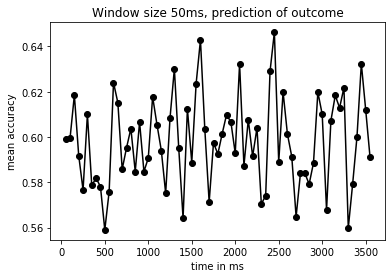

In [113]:
fig = window_prediction_all_LDA(df, random_X, outcome_random, 120, 50)
plt.savefig("50ms_prediction_random_trial")